# Exploring and Predicting University Faculty Salaries

<img src='Penn_State.jpg' width = 800, height = 600>
[Source](http://de.wikipedia.org/wiki/Pennsylvania_State_University)

Although data about faculty salaries at private universities can be difficult to find, getting data regarding faculty salaries at public universities is much easier. I've always been curious (even though I don't want to go into academia myself!) which fields pay the best and why and if there is a way to predict your salary if you are going to be a professor at a certain university. 

So, I decided to make this a project I would explore and use two of the very best data science tools to do it: Python and R! Thanks to the rpy2 library and IPython's R magic, I can now include R code inside the notebook instead of having to switch between knitr and here. The first half will be about cleaning and EDA (exploratory data analysis): a key first step of any data science project dealing with structured data especially. The second half will be about machine learning and applying a model for regression. 

While Python is making improvements in [visualization](http://stanford.edu/~mwaskom/software/seaborn/), I still prefer R for this part. Combining the great tools of the [plyr library](http://plyr.had.co.nz/) for splitting the data into pieces with the beautiful visualization of the [ggplot2 library](http://docs.ggplot2.org/current/) makes this look much better than Python's current offerings. 

## Getting the Data

For this project, I decided to choose my current university: [Texas A&M](http://www.tamu.edu/). It's a large university, which means it also has a lot of faculty members to look at! The Texas Tribune publishes salary data each year from the university [here](http://salaries.texastribune.org/agencies/). 

We only need the data from Texas A&M, no other extension agencies. 

Here is part of the problem though: all of the files we can download are .xlsx Excel files. R doesn't read these very well (although there are some workarounds). The best way is to save them as a .csv file first, then read them in using read.csv. 

Pandas can read Excel files, however. Let's get the files using Pandas, then save them as .csv files locally. Once that is done, we can load them into R.

In [1]:
import pandas as pd
texasAM_file = pd.read_excel('http://raw.texastribune.org.s3.amazonaws.com' + 
                        '/texas_a%26m_university_system/salaries/2014-01/Hill%20-%20SO-14-003.xlsx') # Download the file.

In [2]:
texasAM_file.to_csv('TexasAM_Salaries.csv') # Save the data as a .csv

## Cleaning It Up

It is time to play around with some of IPython Notebook's lovely interaction with R using the [rpy2 library](http://rpy.sourceforge.net/) and the R magic. Note to Windows users: this probably won't work very well for you as rpy2 doesn't play nicely with Windows! You could use a virtual machine with Linux to get around this if you wish.

Let's load all of the libraries we will need in R first.

In [48]:
%load_ext rpy2.ipython

In [49]:
%%R # You need this to use a block of R code.
library(plyr)
library(ggplot2)
library(scales)

Now that we have all of our libraries loaded, let's load our data into R and take a look at it.

In [50]:
%%R
salaryDB <- read.csv('TexasAM_Salaries.csv', header = TRUE, stringsAsFactors = FALSE)
print(head(salaryDB))

  X                     MbrName      LastName FirstName     ShortTitleDesc
1 0 Prairie View A&M University        ABBASI    HASSAN  INFO RESOURCE SUP
2 1 Prairie View A&M University        ABBASI   HUSSAIN  INFO RESOURCE SUP
3 2 Prairie View A&M University         ABIBO    IBUOMI   SPEC WEB CONTENT
4 3 Prairie View A&M University ABROM-JOHNSON TENEINGER ADJUNCT INSTRUCTOR
5 4 Prairie View A&M University         ADAMS     BETTY        PROF & DEAN
6 5 Prairie View A&M University         ADAMS    GLORIA     ADMIN ASST III
        ShortAdlocDesc EEOMinorityCode Sex        CurrEmplDate
1 INFORMATION RESOURCE               4   M 2009-05-15 00:00:00
2      ADMIN & RECORDS               4   M 2010-07-15 00:00:00
3 ADLOC COOP EXTENSION               2   M 2013-02-15 00:00:00
4 AG. NUTR & HUMAN ECO               2   F 1990-12-17 00:00:00
5  OFF.OF ACADEMIC AFF               2   F 2000-06-01 00:00:00
6    UNIVERSITY POLICE               2   F 1988-11-01 00:00:00
         OrigEmplDate BudgetedSala

Clearly there are some issues we will need to address. First of all, we can see other universities were included in the database that are NOT a part of Texas A&M. For this study we are only looking at Texas A&M faculty, so let's only include rows under the 'MbrName' column that are either part of Texas A&M or the Health Science Center. Let's also trim this down a bit and get rid of the 'X' and 'CurrEmplDate' columns as we won't need them for our analysis.

In [51]:
%%R
salaryDB <- subset(salaryDB, MbrName == 'Texas A&M University' | MbrName == 'Texas A&M Health Science Center', 
                   select = -c(CurrEmplDate, X))

Let's see a summary of our datatypes.

In [52]:
%%R
str(salaryDB)

'data.frame':	9234 obs. of  9 variables:
 $ MbrName        : chr  "Texas A&M Health Science Center" "Texas A&M Health Science Center" "Texas A&M Health Science Center" "Texas A&M Health Science Center" ...
 $ LastName       : chr  "ABBEY" "ABRAHAM" "ACOSTA" "ADAMS" ...
 $ FirstName      : chr  "COLETTE" "CELESTE" "IDALIA" "JOYCE" ...
 $ ShortTitleDesc : chr  "RESEARCH ASSOCIATE" "ASSOCIATE PROFESSOR" "ADMIN COORDINATOR" "BUS ADMIN I" ...
 $ ShortAdlocDesc : chr  "MOLECULAR & CELL MED" "PERIODONTICS" "HEALTH POL & MGMT" "REGENERATIVE MED" ...
 $ EEOMinorityCode: num  1 4 3 1 3 1 1 1 4 3 ...
 $ Sex            : chr  "F" "F" "F" "F" ...
 $ OrigEmplDate   : chr  "1992-09-10 00:00:00" "1993-06-21 00:00:00" "1995-08-14 00:00:00" "2008-09-15 00:00:00" ...
 $ BudgetedSalary : int  41600 107362 55782 52500 54000 185001 5111 35144 40315 15900 ...


For this project, we are looking at tenure-track faculty only. We want to get rid of other employees such as "BUS ADMIN I". As a start, let's remove all employees that don't have "Professor" in their title (from the ShortTitleDesc field).

In [53]:
%%R
salaryDB <- salaryDB[grep('PROF', salaryDB$ShortTitleDesc),]

In [54]:
%%R
dim(salaryDB)

[1] 2818    9


We have reduced the number of employees a lot, from 9234 to 2818. 

The next thing we want to do is change the OrigEmplDate column to something more meaningful. Instead, let's make it the number of years they have worked at the university. We can use this as one of our features later. 

The metadata at the website where we obtained the original salary data says that it was uploaded on Jan 15, 2014. Let's find the difference between that date and the original employment date for all of our employees.

In [55]:
%%R
origDate <- as.Date('2014-01-15') # This is the format R likes: YYYY-MM-DD.
salaryDB$OrigEmplDate <- as.Date(salaryDB$OrigEmplDate) # Get this into the Date form R likes for finding differences 
                                                                    # between dates.
salaryDB$OrigEmplDate <- as.numeric((origDate-salaryDB$OrigEmplDate)/365.) # Calculate the difference and divide by 365 for number of 
                                                                           # years.
colnames(salaryDB)[8] <- 'YearsWorked' # Use a more informative column title.

Let's just check to make sure it worked.

In [56]:
%%R
head(salaryDB)

                             MbrName  LastName FirstName      ShortTitleDesc
5892 Texas A&M Health Science Center   ABRAHAM   CELESTE ASSOCIATE PROFESSOR
5896 Texas A&M Health Science Center     ADAMS       RAE ASSISTANT PROFESSOR
5897 Texas A&M Health Science Center     ADAMS     TERRY  CLINICAL ASST PROF
5905 Texas A&M Health Science Center AL ROUSAN     RABAA ASSISTANT PROFESSOR
5906 Texas A&M Health Science Center ALAJLOUNI  KHALDOUN     CLIN ASSOC PROF
5908 Texas A&M Health Science Center    ALANIZ    ROBERT ASSISTANT PROFESSOR
           ShortAdlocDesc EEOMinorityCode Sex YearsWorked BudgetedSalary
5892         PERIODONTICS               4   F  20.5835616         107362
5896 TX A&M FAMILY MED RE               1   F  10.5890411         185001
5897         ORTHODONTICS               1   M  17.3205479           5111
5905   PHARMACY-ACAD SUPP              NA   F   0.2712329          92500
5906 RESTORATIVE SCIENCES               1   M   8.0438356          16840
5908 MICRO PATH & IMMUN

That seems correct. The next thing we are going to do is create another feature: college. All of the departments at universities are organized into colleges. At Texas A&M, that means [12 major colleges](http://www.tamu.edu/about/departments.html). This is somewhat tedious work, but we want to organize all of the faculty members by college as a feature.

Let's get a list of all of the different departments included first.

In [57]:
%%R
colnames(salaryDB)[5] <- 'Dept' # Much better title for this column!
deptLevels <- as.factor(salaryDB$Dept)
print(summary(deptLevels))

         MATHEMATICS HEALTH & KINESIOLOGY         QATAR CAMPUS 
                 102                   96                   66 
 PHYSICS & ASTRONOMY   TAMU SCHOOL OF LAW DEPT HEAD-ELECT ENGR 
                  64                   62                   58 
   CIVIL ENGINEERING RESTORATIVE SCIENCES     LIBRARY DIRECTOR 
                  57                   54                   51 
             ENGLISH            CHEMISTRY  DEPT HEAD-MECH ENGR 
                  48                   47                   47 
EDUCATIONAL PSYCHOLO              HISTORY              BIOLOGY 
                  47                   47                   46 
VET INTEGRATIVE BIOS VET MED PATHOBIOLOGY           PSYCHOLOGY 
                  44                   43                   41 
  PHARMACY-ACAD SUPP   TEACHING, LEARNING         ARCHITECTURE 
                  38                   35                   34 
  BUSH SCHOOL OF GOV    POLITICAL SCIENCE VET MED SMALL ANIMAL 
                  34                   3

Quite a large variety of departments listed here. To be consistent with the college labelings on the university's website, I will only label a department as part of a college if it is specifically mentioned. We will create a variety of department lists of statements we can grep for each college, then assign a college number. Data science is sometimes a little messy!

In [58]:
%%R
# Include a large list of department terms we can use grep on so that each faculty member is grouped by college.

agList <- c('AG EC', 'AG ED', 'ANIMAL SC', 'BIOCHEM', 'ECOS', 'ENTO', 'HORTI', 'NUTRI', 'PLANT P',
             'POULTRY', 'REC,', 'SOIL', 'WILDLIFE') # College of Agriculture

archList <- c('ARCHI', 'CONSTR', 'LANDS', 'VISUALIZ') # College of Architecture

bushList <- 'BUSH SCH' # Bush School

maysList <- c('ACCOUNTING', 'FINANC', 'INFO & OP', 'MANAGEM', 'MARKET', 'MBA') # Business school

eduList <- c('DEAN OF ED', 'TEACHING,', 'EDUCATIONAL PSYC', 'HEALTH &', 'EAHR') # Education/Human Development

engrList <- c('ENGR', 'COMPUTER', 'CIVIL', 'MATERIALS', 'BIOMEDICAL ENG', 'AEROSPACE', 'AG ENGINEER') # Engineering

earthList <- c('GEO', 'OCEAN', 'METEO') # Geoscience (my college)

libList <- c('ANTHRO', 'COMMUN', '^ECON', 'ENGL', 'HISTORY', 'INTERN', 'HISP', 'PERFORM', 'PHILO',
             'POLITICAL', 'PSYCHOLOGY', 'SOCIO', 'LIBERAL') # Liberal Arts

sciList <- c('^BIOLOGY', 'CHEMISTRY', 'MATH', 'ASTR', 'STATISTICS') # Science

vetList <- c('VET', 'BIOMEDICAL SCI', 'LARGE AN') # Vet School

Now that we have our grep lists, make our new feature and assign a number for each college.

In [59]:
%%R

salaryDB$College <- 0 # Initialize our new feature

salaryDB$College[grep(paste(agList, collapse = '|'), salaryDB$Dept)]  <- 1 # Ag and Life Sciences

salaryDB$College[grep(paste(archList, collapse = '|'), salaryDB$Dept)] <- 2 # Architecture

salaryDB$College[grep(paste(bushList, collapse = '|'), salaryDB$Dept)] <- 3 # Bush school

salaryDB$College[grep(paste(maysList, collapse = '|'), salaryDB$Dept)] <- 4 # Mays Business school

salaryDB$College[grep(paste(eduList, collapse = '|'), salaryDB$Dept)] <- 5 # Education/Human Development 

salaryDB$College[grep(paste(engrList, collapse = '|'), salaryDB$Dept)] <- 6 # Engineering

salaryDB$College[grep(paste(earthList, collapse = '|'), salaryDB$Dept)] <- 7 # Geosciences

salaryDB$College[salaryDB$MbrName == 'Texas A&M Health Science Center'] <- 8 # Health Science Center

salaryDB$College[salaryDB$Dept == 'TAMU SCHOOL OF LAW'] <- 9 # Law school

salaryDB$College[grep(paste(libList, collapse = '|'), salaryDB$Dept)] <- 10 # Liberal Arts

salaryDB$College[grep(paste(sciList, collapse = '|'), salaryDB$Dept)] <- 11 # Science

salaryDB$College[grep(paste(vetList, collapse = '|'), salaryDB$Dept)] <- 12 # Veterinary Medicine/Biomedical

If we couldn't include someone in a college, we are going to drop them from the dataframe. This includes people at the Qatar campus, as well as library staff, deans, etc.

In [60]:
%%R

salaryDB <- subset(salaryDB, College > 0) # Only include people that have been assigned a college.

Let's see how our dataframe looks now.

In [61]:
%%R
head(salaryDB)

                             MbrName  LastName FirstName      ShortTitleDesc
5892 Texas A&M Health Science Center   ABRAHAM   CELESTE ASSOCIATE PROFESSOR
5896 Texas A&M Health Science Center     ADAMS       RAE ASSISTANT PROFESSOR
5897 Texas A&M Health Science Center     ADAMS     TERRY  CLINICAL ASST PROF
5905 Texas A&M Health Science Center AL ROUSAN     RABAA ASSISTANT PROFESSOR
5906 Texas A&M Health Science Center ALAJLOUNI  KHALDOUN     CLIN ASSOC PROF
5908 Texas A&M Health Science Center    ALANIZ    ROBERT ASSISTANT PROFESSOR
                     Dept EEOMinorityCode Sex YearsWorked BudgetedSalary
5892         PERIODONTICS               4   F  20.5835616         107362
5896 TX A&M FAMILY MED RE               1   F  10.5890411         185001
5897         ORTHODONTICS               1   M  17.3205479           5111
5905   PHARMACY-ACAD SUPP              NA   F   0.2712329          92500
5906 RESTORATIVE SCIENCES               1   M   8.0438356          16840
5908 MICRO PATH & IMMUN

Let's include another feature for our dataset, tenure ranking. There are three basic levels: assistant, associate, and full. Assistant means you haven't reached tenure yet, which takes about 5 years or so after you start (and is not guaranteed!) Once you get tenure, you are promoted to associate rank. Do more good work, and you can reach the rank of full professor. Salary is clearly going to be somewhat dependent on this, so let's see if we can include this as an additional feature. 

As you can see in the head of our dataframe, the professors have their rank included in the "ShortTitleDesc" column. Let's use grep again to assign each professor a rank category.

In [62]:
%%R

salaryDB$Rank <- 0 # Initialize the feature.
salaryDB$Rank[grep('ASSISTANT|ASST', salaryDB$ShortTitleDesc)] <- 1 # Assistant prof
salaryDB$Rank[grep('ASSOCIATE|ASSOC PROF', salaryDB$ShortTitleDesc)] <- 2 # Associate prof
salaryDB$Rank[grep('^PROFESSOR|^PROF|DISTINGUISHED|SENIOR', salaryDB$ShortTitleDesc)] <- 3 # Full prof

However, there were some other professors that remained we don't want to be including in our dataset (such as adjuncts or visiting professors). Let's give them a label of 0 to reset them. Then, get rid of any other faculty members that aren't in one of these three categories.

In [63]:
%%R

salaryDB$Rank[grep('ADJ|VISITING|CLIN|INSTRUCT|RES|PRACT', salaryDB$ShortTitleDesc)] <- 0 # Non tenure-track.
salaryDB <- subset(salaryDB, Rank > 0) # Get rid of any faculty members not falling in one of the three rank categories.

Let's see how our dataframe is looking (and how many faculty members are left!)

In [64]:
%%R

head(salaryDB)

                             MbrName   LastName FirstName      ShortTitleDesc
5892 Texas A&M Health Science Center    ABRAHAM   CELESTE ASSOCIATE PROFESSOR
5896 Texas A&M Health Science Center      ADAMS       RAE ASSISTANT PROFESSOR
5905 Texas A&M Health Science Center  AL ROUSAN     RABAA ASSISTANT PROFESSOR
5908 Texas A&M Health Science Center     ALANIZ    ROBERT ASSISTANT PROFESSOR
5910 Texas A&M Health Science Center  ALEXANDER     JAMES ASSOCIATE PROFESSOR
5914 Texas A&M Health Science Center AL-HASHIMI   IBTISAM           PROFESSOR
                     Dept EEOMinorityCode Sex YearsWorked BudgetedSalary
5892         PERIODONTICS               4   F  20.5835616         107362
5896 TX A&M FAMILY MED RE               1   F  10.5890411         185001
5905   PHARMACY-ACAD SUPP              NA   F   0.2712329          92500
5908 MICRO PATH & IMMUNOL               3   M   5.9589041          88642
5910    HEALTH POL & MGMT               1   M  12.8849315         113130
5914         PER

In [65]:
%%R
dim(salaryDB)

[1] 2085   11


Looking at the third entrant, we can see a problem that will need to be fixed. Some of the "EEOMinorityCode" entrants are NA. That could be an issue later on. Let's see how many. 

In [66]:
%%R
summary(salaryDB$EEOMinorityCode)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  1.000   1.000   1.000   1.719   2.000   7.000      16 


Let's examine these NA faculty members and see what we can do to fix this.

In [67]:
%%R
subset(salaryDB, is.na(EEOMinorityCode))

                              MbrName         LastName FirstName
5905  Texas A&M Health Science Center        AL ROUSAN     RABAA
6250  Texas A&M Health Science Center          DRANETZ     DAVID
6634  Texas A&M Health Science Center              KOO CATHY LAU
7348  Texas A&M Health Science Center            WELLS     GREGG
7401  Texas A&M Health Science Center       WOODMANSEY      KARL
10418            Texas A&M University         CUMMINGS     KEVIN
10911            Texas A&M University           EUSEBI   RICARDO
11247            Texas A&M University           GEORGE  THEODORE
12887            Texas A&M University        LIGHTFOOT      JOHN
13169            Texas A&M University         MARKOVIC     MILAN
13354            Texas A&M University          MCINNES     KEVIN
14628            Texas A&M University             RICE     SARAH
14773            Texas A&M University           ROGERS   WILLIAM
15900            Texas A&M University            USTER     HALIT
15991            Texas A&

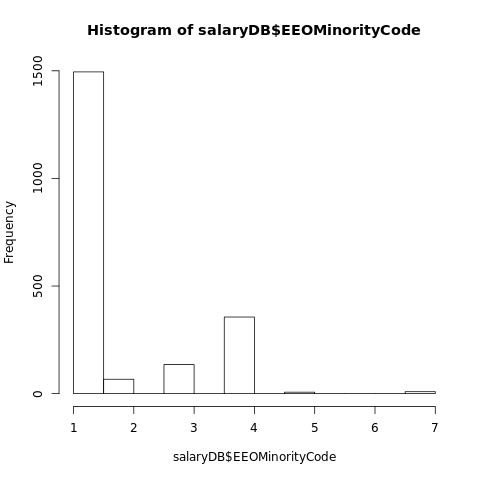

In [68]:
%%R
hist(salaryDB$EEOMinorityCode)

Examining the histogram, we can see that the faculty members predominantly fall in category 1 (white). Category 2 represents Black/African-American, category 3 is Latino, and category 4 is Asian. Category 5 represents more than one race (mixed) while category 7 represents Native American. 

While it is not ideal, we can guess the race based on the names of the NA members. White is by far the most common category, so we will assign all remaining faculty members to this category for now.

In [69]:
%%R
salaryDB$EEOMinorityCode[is.na(salaryDB$EEOMinorityCode == TRUE)] <- 1 # Assign all NA to 1 for White.
salaryDB$EEOMinorityCode[salaryDB$LastName == 'KOO'] <- 4
salaryDB$EEOMinorityCode[salaryDB$LastName == 'VIEIRA-DE-CASTRO'] <- 3 # Correct two of them.



In [70]:
%%R
summary(salaryDB$EEOMinorityCode)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.716   2.000   7.000 


No more NA values. 

Now, we need to relabel the Sex category in terms of numbers to give it One-Hot encoding. This is easy for Sex since there are only two possibilities anyway. Let's add this as a new feature.


In [71]:
%%R
library(plyr)
salaryDB$SexCode <- as.numeric(revalue(salaryDB$Sex, c('M' = 0, 'F' = 1)))

We also need to give each department a number as well. Thankfully, R makes this very easy to do.

In [72]:
%%R
salaryDB$DeptCode <- as.numeric(as.factor(salaryDB$Dept))

Taking a look at our frame now:

In [73]:
%%R
head(salaryDB)

                             MbrName   LastName FirstName      ShortTitleDesc
5892 Texas A&M Health Science Center    ABRAHAM   CELESTE ASSOCIATE PROFESSOR
5896 Texas A&M Health Science Center      ADAMS       RAE ASSISTANT PROFESSOR
5905 Texas A&M Health Science Center  AL ROUSAN     RABAA ASSISTANT PROFESSOR
5908 Texas A&M Health Science Center     ALANIZ    ROBERT ASSISTANT PROFESSOR
5910 Texas A&M Health Science Center  ALEXANDER     JAMES ASSOCIATE PROFESSOR
5914 Texas A&M Health Science Center AL-HASHIMI   IBTISAM           PROFESSOR
                     Dept EEOMinorityCode Sex YearsWorked BudgetedSalary
5892         PERIODONTICS               4   F  20.5835616         107362
5896 TX A&M FAMILY MED RE               1   F  10.5890411         185001
5905   PHARMACY-ACAD SUPP               1   F   0.2712329          92500
5908 MICRO PATH & IMMUNOL               3   M   5.9589041          88642
5910    HEALTH POL & MGMT               1   M  12.8849315         113130
5914         PER

To help prepare us for the second part of this notebook (the machine learning section), we will need to create a second dataframe that only has numbers as inputs. 

Let's create that now, along with some renaming of the Minority Code feature.

In [74]:
%%R
numericDB <- subset(salaryDB, select = -c(MbrName, LastName, FirstName, ShortTitleDesc, Dept, Sex)) 
# This removes the non-numeric features.

colnames(numericDB)[1] <- 'Race' # Change the column name.
numericDB$BudgetedSalary <- as.numeric(numericDB$BudgetedSalary) # Get all features to be numeric.

In [75]:
%%R
str(numericDB)

'data.frame':	2085 obs. of  7 variables:
 $ Race          : num  4 1 1 3 1 1 1 1 1 1 ...
 $ YearsWorked   : num  20.584 10.589 0.271 5.959 12.885 ...
 $ BudgetedSalary: num  107362 185001 92500 88642 113130 ...
 $ College       : num  8 8 8 8 8 8 8 8 8 8 ...
 $ Rank          : num  2 1 1 1 2 3 1 3 3 2 ...
 $ SexCode       : num  1 1 1 0 0 1 0 0 0 1 ...
 $ DeptCode      : num  93 113 94 83 58 93 85 73 84 83 ...


Our dataframe now has some new features, along with converting all of the categorical features to numeric ones. We have also gotten rid of all NA values. Our data is now (finally) clean! We can now start the next phase.

## Exploratory Data Analysis

In this section, we will try some visualization of the salary data to find any interesting patterns or other existing problems with the data we may have missed. 

There are several interesting ways we could look at this data (feel free to play around with it!). I am going to choose a few of the more interesting patterns. To do that, we will use the libraries plyr to shape the data and ggplot2 for visualization. These two are a powerful combination for exploring data.

First thing we are going to do is make a very nice plotting function that we can call to help visualize the data quickly and efficiently.
Let's make that now.

In [76]:
%%R

PrettyDensPlot <- function(variable, name){
  # This function will take in a dataset in dataframe format and plot
  # a pretty density function along with the median value.
  
  df <- as.data.frame(variable) # Get it into a dataframe.
  # Calculate the median value:
  mid <- median(variable, na.rm = TRUE)
  # Make this a separate dataframe.
  middle <- data.frame(mid)
  
  # Now plot with our label intact.
  
  finalPlot <- ggplot(df) + 
    geom_density(aes(x = variable), adjust = 2.0, color = 'black', size = 1.5, fill = 'skyblue') +
    scale_x_log10(breaks=c(1000,10000,100000,1000000), labels=dollar) +
    annotation_logticks(sides="bt")
  
  afterPlot <- finalPlot + geom_vline(data = middle, aes(xintercept = mid,
                                                         linetype = 'Median', size = 'Median', 
                                                         color = 'Median'), show_guide = T) + 
    scale_color_manual(name = '', values = 'red') + 
    scale_linetype_manual(name = '', values = 'longdash') + 
    scale_size_manual(name = '', values = 1.0) + 
    xlab(name)
  
  
  
  
  # Display it.
  
  print(afterPlot)
  
  
}

This function will make a nice looking density plot of our salaries to see the distribution, along with the median value for comparison. Let's call it now.

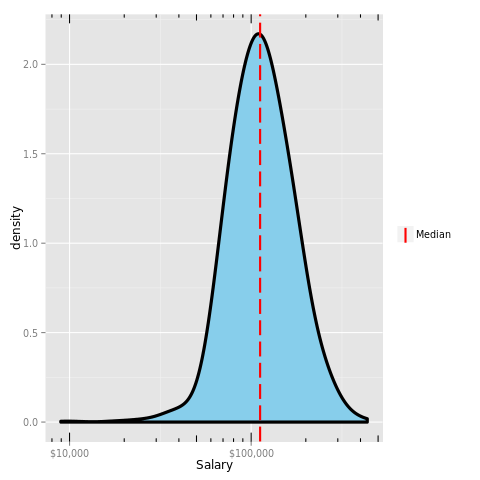

In [77]:
%%R
PrettyDensPlot(numericDB$BudgetedSalary, 'Salary')

Looks like the median salary is right around the 110,000 dollar mark. The distribution looks to have a bit of a tail on the lower end. Remember that the plot marks below show a logarithmic distribution of salary data, which you often need. Salary data is very rarely normally distributed without a log transformation. Therefore, a summary statistic such as the median will usually be more informative about the distribution than the mean.

Let's see if gender has any effect on salary next.

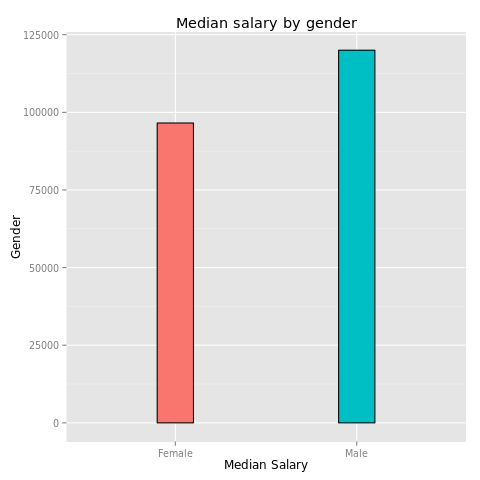

In [78]:
%%R
sexFrame <- ddply(numericDB,~SexCode,summarize,median=median(BudgetedSalary)) # Use ddply from plyr to get the median salary by sex.

sexFrame[1,1]  <- 'Male'
sexFrame[2,1] <- 'Female' # For plotting purposes


sexBarPlot <- ggplot(sexFrame, aes(x=SexCode, y=median, fill=SexCode)) +
  geom_bar(color="black", stat="identity", width = 0.2) +
  guides(fill=FALSE)+
  xlab('Median Salary') + 
  ylab('Gender') + 
  ggtitle('Median salary by gender') # Create our ggplot figure

print(sexBarPlot) # Show it

Clearly males have a higher median salary than females do, with males showing close to 120,000 and females close to 95,000. 

Let's do a more complicated plot that breaks things down by race AND gender to see which matters more.

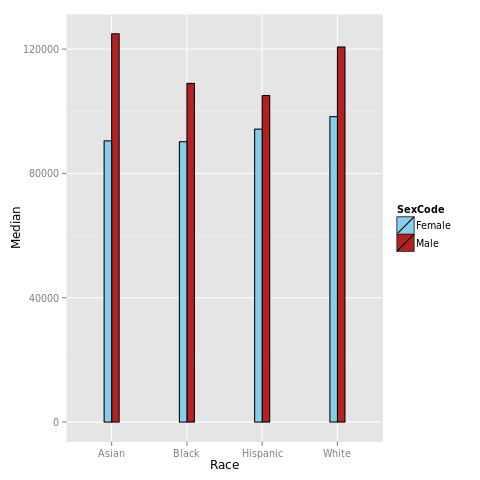

In [79]:
%%R
raceFrame <- ddply(numericDB, .(Race,SexCode),summarize, Median = median(BudgetedSalary)) # Use ddply to get medians on both sex/race.

# Get rid of last four rows.

raceFrame <- raceFrame[1:8,]

# Replace the race/gender codes.

raceFrame$Race <- mapvalues(raceFrame$Race, c(1,2,3,4),
                            c('White', 'Black', 'Hispanic', 'Asian'))
raceFrame$SexCode <- mapvalues(raceFrame$SexCode, c(0,1), c('Male', 'Female')) # Put in the appropriate plot labels

sexRacePlot <- ggplot(raceFrame, aes(x=Race, y=Median, fill=SexCode)) + 
    geom_bar(stat="identity", position=position_dodge(), color="black", width = 0.2) + 
    scale_fill_manual(values = c('skyblue', 'firebrick')) # Crate our barplot

print(sexRacePlot) # Show it

It does seem that women do make less money than men, regardless of race. The largest gap is somewhat surprising in Asians. Asian men have the greatest median salary among races, yet Asian women have the smallest! Hispanic faculty members seem to have the smallest wage gap by sex.

Next, let's examine how tenure ranking affects the salary. There should be an increase in median salary for higher ranks.

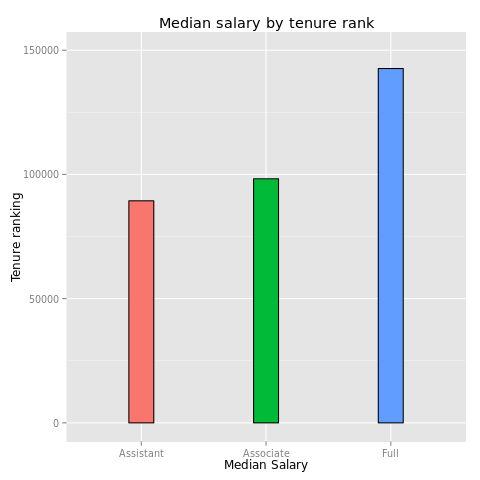

In [80]:
%%R

rankFrame <- ddply(numericDB,~Rank,summarize,Median=median(BudgetedSalary)) # Use ddply to find medians by Rank

rankFrame$Rank <- mapvalues(rankFrame$Rank, c(1,2,3),
                            c('Assistant', 'Associate', 'Full')) # Create our labels

rankPlot <- ggplot(rankFrame, aes(x=Rank, y=Median, fill=Rank)) +
  geom_bar(color="black", stat="identity", width = 0.2) +
  guides(fill=FALSE) +
  xlab('Median Salary') + 
  ylab('Tenure ranking') + 
  ylim(c(0,150000)) +
  ggtitle('Median salary by tenure rank') # Make our plot

print(rankPlot)

It appears that going from Assistant to Associate professor, according to the median, will increase the salary by only about 10,000 dollars a year. That doesn't seem like very much! Full rank definitely seems to provide quite the salary boost, however. This could be biased somewhat, however, because Full is the highest rank we have, meaning professors that have been around for ten years and thirty years fall into this category, so the median will be increased. 

Now let's see how salaries rank according to which of the 12 colleges you are in.

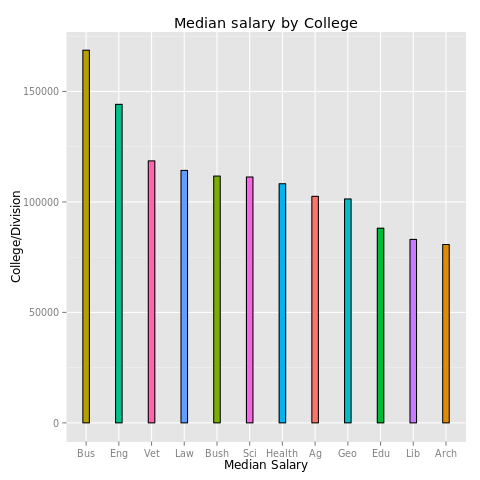

In [81]:
%%R

collegeFrame <- ddply(numericDB,~College,summarize,Median=median(BudgetedSalary))

collegeFrame$College <- mapvalues(collegeFrame$College, c(1,2,3,4,5,6,7,8,9,10,11,12),
                                  c('Ag', 'Arch', 'Bush', 'Bus', 'Edu',
                                    'Eng', 'Geo', 'Health', 'Law', 'Lib', 'Sci',
                                    'Vet')) # Map all of the college names

collegePlot <- ggplot(collegeFrame, aes(x=reorder(College, -Median), y=Median, fill=College)) + # Use the argument reorder 
  geom_bar(color="black", stat="identity", width = 0.2) +
  guides(fill=FALSE) +
  xlab('Median Salary') + 
  ylab('College/Division') + 
  ggtitle('Median salary by College')

 print(collegePlot)

I had to shorten the names so they would all fit, but hopefully you can understand what they are. Being a professor in the Business school definitely makes a good living! It is far ahead of the other colleges. Engineering isn't far behind, which is understandable, especially since Texas A&M is known for having a large Engineering college. Liberal Arts and Architecture are the lowest paying, which makes sense considering the conventional wisdom regarding salaries in those fields. 

Last, let's examine salaries for a few departments. To do that, we will need the information from the larger, original dataframe we made that has the department titles.

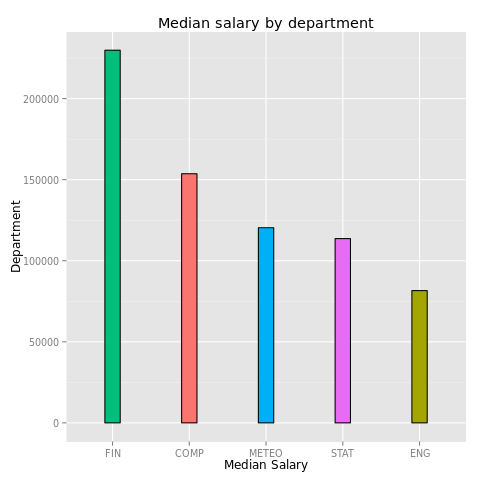

In [82]:
%%R

sortedDept <- ddply(salaryDB,~Dept,summarize,median=median(BudgetedSalary)) # Get the median salaries by department


# Pick a few major departments that aren't admin or academic coordinators. We will use grep to find them. 

deptList <- c('FINANCE', 'COMPUTER', 
              'ENGLISH', 'STATISTICS', 'METEOR')

deptFrame <- sortedDept[grep(paste(deptList, collapse = '|'), sortedDept$Dept),]

deptFrame$Dept <- mapvalues(deptFrame$Dept, c('DEPT OF STATISTICS', 'ENGLISH', 'FINANCE',
                                             'HD, COMPUTER SCI', 'METEOROLOGY'),
                            c('STAT', 'ENG', 'FIN', 'COMP', 'METEO')) # To make the titles visible

deptPlot <- ggplot(deptFrame, aes(x=reorder(Dept, -median), y=median, fill=Dept)) +
  geom_bar(color="black", stat="identity", width = 0.2) +
  guides(fill=FALSE) +
  xlab('Median Salary') + 
  ylab('Department') + 
  ggtitle('Median salary by department')

print(deptPlot)

As you can see in the code, FIN = Finance, COMP = Computer Science, METEO = Meteorology, STAT = Statistics, and ENG = English. My current field, Meteorology, falls somewhere in between Computer Science and Statistics (the two main branches of Data Science). Finance sure pays a lot, while English not quite as much. 

Our last step for finishing with R is to output our final numeric dataframe and save it as a .csv, where Python will take over for the machine learning portion of this notebook. We are going to save two different dataframes. The first will be our numeric frame, while the second will be a lookup table we can create easily for Python. This will come in handy later when we implement our machine learning algorithm. 

In [83]:
%%R

# First, create a new data frame that only extracts the dept name, dept id, and college number. 

lookupFrame <- subset(salaryDB, select = c(Dept, College, DeptCode))
lookupFrame <- unique(lookupFrame) # Get the unique values only
write.csv(lookupFrame, 'DeptLookup.csv') # save it
write.csv(numericDB, 'FinalSalaryFrame.csv') # save our numeric frame

## EDA Summary and Conclusions

We have obtained an external data source, cleaned it up, transformed the data, added new features, and did some exploration of the data. Believe it or not, this work actually ends up taking most of a Data Scientist's time! It is very important, as good features make machine learning algorithms work far better than which model you end up choosing, so it is a step that is worth the time investment. 

We will now start Part 2 of this notebook: how to take this new dataset and make a predictive model out of it that we can actually use. While this work could be done in R, I personally think Python has better Machine Learning capabilities and can be more easily integrated into existing code than R can.

# Part 2: Regression Model to Predict Salaries at Texas A&M

Now, it is time to switch gears a bit and move back to Python. Our goal is to make a regression model that can be used to predict what your salary would be if you were to become a faculty member at Texas A&M. 

We have done most of the necessary preparation already, but a little more remains. First, let's load our two .csv files into Python via the pandas library. 

In [84]:
# Load our data into a pandas dataframe first. 

salaryDF = pd.read_csv('FinalSalaryFrame.csv', header = 0)
salaryDF.head()

,Unnamed: 0,Race,YearsWorked,BudgetedSalary,College,Rank,SexCode,DeptCode
0,5892,4,20.583562,107362,8,2,1,93
1,5896,1,10.589041,185001,8,1,1,113
2,5905,1,0.271233,92500,8,1,1,94
3,5908,3,5.958904,88642,8,1,0,83
4,5910,1,12.884932,113130,8,2,0,58


Looks like there is an extra column pandas read in. We don't want that, so let's get rid of it.

In [85]:
salaryDF.drop(salaryDF.columns[0], axis = 1, inplace = True)
salaryDF.head()

,Race,YearsWorked,BudgetedSalary,College,Rank,SexCode,DeptCode
0,4,20.583562,107362,8,2,1,93
1,1,10.589041,185001,8,1,1,113
2,1,0.271233,92500,8,1,1,94
3,3,5.958904,88642,8,1,0,83
4,1,12.884932,113130,8,2,0,58


Let's repeat this procedure with our lookup table we will use later.

In [86]:
lookup_table = pd.read_csv('DeptLookup.csv', header = 0)
lookup_table.drop(lookup_table.columns[0], axis = 1, inplace = True)

We want to try a couple of different machine learning algorithms for this project. If we were only using a tree method (such as Random Forests or Gradient Boosted Regression Trees), we wouldn't need to alter our data: just run it as is. This is what is convenient about tree methods. However, it may be helpful to also have another algorithm to compare to, such as linear regression. If you are going to use regularization with linear regression (you should!), it requires us to apply two things:

- Feature Scaling
- One-Hot Encoding

Trees don't care about this, but to set the proper weights for the features in linear regression (and apply regularization appropriately), [we need to scale our numerical features](http://scikit-learn.org/stable/modules/preprocessing.html). We need One-Hot Encoding for the categorical features because otherwise linear regression will think College 8 is greater than College 1. That isn't really a comparison; they should be treated equally by the regressor. 


Let's take care of this now while we can.

First, let's take care of the One-Hot Encoding. We only need to apply this to the categorical variables.

In [87]:
from sklearn.preprocessing import OneHotEncoder

# Get the categorical features only

categDF = salaryDF[['Race', 'College', 'Rank', 'SexCode', 'DeptCode']]
encoder = OneHotEncoder() # Create the encoder object
categDF_encoded = encoder.fit_transform(categDF).toarray() # want it as numpy array since it is not too large 
                                                            # tree algorithms in scikit-learn can't use sparse arrays yet    

Now that all of our categorical variables are in zeros and ones, let's add our last feature to the numpy array to create our final feature matrix.

In [88]:
yrs_worked = salaryDF['YearsWorked'].values

# Now combine this with the rest of our features.

import numpy as np

x_final = np.c_[yrs_worked, categDF_encoded]

Let's get our salaries as the target. Then, we can create our train/test split.

In [89]:
y_final = salaryDF['BudgetedSalary'].values

from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_final, y_final, test_size = 0.2, random_state = 0) 
# We now have our train/test splits

What about the feature scaling I talked about earlier?

What a lot of people do is scale the features first, then split into test and training sets. It's easier to do, but this is a bad habit.

DO NOT APPLY THE SAME SCALING TO YOUR TRAINING AND TEST SETS! This is a very common mistake and terribly easy to make. The reason you don't do this is because otherwise the mean and standard deviation being calculated for the scaling includes data from the test set (which in theory you aren't supposed to have access to when building the model!)

Instead, what is more "fair" is to first scale your training set only. Then, apply the exact same scaling to the test set, using the training set average and standard deviation instead. This way, the model won't be unfairly biased by information in the test set. Let's do that here.

In [90]:
from sklearn.preprocessing import StandardScaler # Get the scaler class

scaler = StandardScaler() # Create our scaling object
x_train[:,0] = scaler.fit_transform(x_train[:,0]) # Replace our YearsWorked column with the scaled values.
x_test[:,0] = scaler.transform(x_test[:,0]) # Apply same transformation to our test values.

You don't need to apply feature scaling to the target, however, so our work is done. Now we have our arrays ready to go in the proper format.

## Creating Our Models

Similar to the first project I showed regarding classification of movie reviews, we are going to use GridSearch from scikit-learn to help tune our models.

The first model we are going to try to start with is linear regression with L2 regularization (also known as [ridge regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge)). There is a built-in normalization (feature scaling) option, but since we also have categorical variables that are one-hot encoded, this wouldn't work very well. 

Let's set up a ridge regressor with 10 different values for the regularization parameter (alpha). You will need to wait about 30 seconds or so for all of the grid search runs to be completed.

In [91]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

ridge_params = {'alpha':np.linspace(1,10,10)} # Try alpha values ranging from 1 to 10.

ridge_model = GridSearchCV(Ridge(), ridge_params, scoring = 'mean_absolute_error', cv = 20) # Run a grid search on all 10, with 20-fold
                                                                                            # cross-validation


# Fit the model. 

ridge_model.fit(x_train, y_train)

# See how well it did.

y_true, y_pred = y_test, ridge_model.predict(x_test)

print 'Mean absolute error of ridge regression was:'
print(mean_absolute_error(y_true, y_pred))

Mean absolute error of ridge regression was:
20088.8770539


Okay, now we have a model as a baseline to compare against. Typically, [Gradient Boosted Regression Trees](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor) are the go-to solution for any regression problem that doesn't involve a large number of training examples/features (greater than 100,000 or so). They allow non-linear interactions between features that linear regression can't do, so it tends to be more accurate. 

However, it requires a LOT of tuning for maximum optimization. I spent a fair amount of time trying several different settings to see what worked the best, so it will save us some time here. Let's now use the GBRT model and see if it improves our mean absolute error. This is a more complicated model than ridge regression, so we will have to wait longer for it to be finished.

In [92]:
from sklearn.ensemble import GradientBoostingRegressor as GBRT

gbrt_params = {'learning_rate':[0.01], 
                'max_depth':[6],
                'min_samples_leaf':[3],
                'n_estimators':[1000]} 
                # Found these after a lot of experimentation with gridsearch. You can try tuning these to see what results you get.
    
model_gbrt = GridSearchCV(GBRT(random_state = 0), gbrt_params, scoring = 'mean_absolute_error') 
                                                  # Turned off CV since I already tested this
                                                             
model_gbrt.fit(x_train, y_train) 

y_true, y_pred = y_test, model_gbrt.predict(x_test)
print 'Mean absolute error of GBRT was:'
print(mean_absolute_error(y_true, y_pred))

Mean absolute error of GBRT was:
20249.1455361


Well that is a little surprising! This is an unexpected result. I tried a lot of different parameters and nothing seems to improve over the ridge regression model. Let's try another model: [random forests](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html). These tend to not work as well for regression problems, but since our GBRT model didn't improve upon the benchmark, let's give them a try. 

Fortunately, these don't require as much tuning and tend to run faster as they can be run in parallel if you have multiple cores. 

In [98]:
from sklearn.ensemble import RandomForestRegressor as RFR

rfr_params = {'min_samples_leaf':[1,3,5],
              'n_estimators':[100,300,500]}

model_rfr = GridSearchCV(RFR(random_state = 0), rfr_params, scoring = 'mean_absolute_error', cv = 5, n_jobs = -1) 
# n_jobs = -1 allows you to parallelize grid search to the number of cores on your machine
                                                                                                          

model_rfr.fit(x_train, y_train)

y_true, y_pred = y_test, model_rfr.predict(x_test)

print 'Mean absolute error of RFR was:'
print(mean_absolute_error(y_true, y_pred))              

Mean absolute error of RFR was:
20329.1548981


No, Random Forests didn't improve our mean absolute error. We need to stick to the ridge regressor. 

Now that we know which model works the best, it would be nice to create a function that allows us to try different input combinations for the model. We will work on this in the next segment.

##Function Implementation

We are now going to create a function to output the results of our model for any combination of parameters we choose. The function will request inputs of race, years of experience, rank (assistant, associate, full), sex, and the department. 

The function will automatically find the associated college from the lookup table we loaded earlier, recombine our inputs and change them to the proper format. Then, the final predicted salary will be displayed. 

In [99]:
def salary_prediction(race = 'W', yrs_experience = 5.0, rank = 'AST', sex = 'M',
                      dept = 'English'):
    '''
    This function will allow you to predict a faculty member's salary based upon the parameters entered.
    
    Inputs:
        Race (B for black, W for white, A for Asian, and H for hispanic)
        Years of Experience (input as a decimal, such as 5.2)
        Tenure rank (AST for assistant, ASC for associate, and FUL for full)
        Sex (M for male, F for female)
        Department (Enter as a string. Function will convert to all capital letters and find
                the college and department code automatically from the lookup table.
                If there is more than one matching department from the title you entered,
                you will given the names and asked to enter again, being more specific.)
                For parts of words that are in multiple departments exactly (such as BIOLOGY),
                use the regex format ^BIOLOGY instead.
    
    Output: Predicted annual salary based on our best model (ridge regression).
    '''

    # Create empty array for storage.

    info_store = np.zeros(5)

    # Load our dicts.

    race_dict = {'W':1, 'B':2, 'H':3, 'A':4}
    rank_dict = {'AST':1, 'ASC':2, 'FUL':3}
    sex_dict = {'M':0, 'F':1}

    # Force our race, rank, sex, and department inputs to all capital letters. This makes it easier in case someone enters
    # lower case instead of upper.

    race = race.upper()
    rank = rank.upper()
    sex  = sex.upper()
    dept = dept.upper()
    yrs_experience = np.array([float(yrs_experience)]) # Force to array type.

    # Now find the appropriate college and department codes from the lookup table defined outside of the function.

    dept_info = lookup_table[lookup_table['Dept'].str.contains(dept)]

    # Loop back and request additional input if more than one department is found as an additional feature.

    while dept_info.shape[0] > 1:
        print 'More than one department found. Matching departments include:'
        for i in dept_info['Dept']:
            print i
        dept = raw_input('Please enter a more specific department:')
        dept = dept.upper() # Fix possible bug when person types it in again.
        dept_info = lookup_table[lookup_table['Dept'].str.contains(dept)] # Try again.
    
    if dept_info.shape[0] < 1:
        print 'No department match found. Try broadening the search (use fewer letters)'
        return # Exit early.
    
     # Now store the appropriate values in our previously empty array.

    info_store[0] = int(race_dict[race])
    info_store[1] = int(dept_info['College'])
    info_store[2] = int(rank_dict[rank])
    info_store[3] = int(sex_dict[sex])
    info_store[4] = int(dept_info['DeptCode']) # Get the numerical equivalent of our department from the lookup table.
    
    # Anyway, now that we have the inputs, combine them together as a test example for the model to predict.
    # Use our scaler from the training set defined earlier in the progam.
    yrs_experience_scaled = scaler.transform(yrs_experience)


    # Now one-hot encode the categorical features the same way.

    combined_onehot = encoder.transform([info_store]).toarray()

    # Merge them together.
    
    # Merge them together.

    final_test_example = np.c_[yrs_experience_scaled, combined_onehot]

# Now predict with this.

    pred_salary = ridge_model.predict(final_test_example)
    print 'The department you chose was:', dept_info['Dept'].values[0]
    print 'Your predicted annual salary is:', '%.2f' % pred_salary[0]

# End of function

Now let's give it a few tries (feel free to experiment with this yourself). 

Our first potential faculty member is a white male with a little over a year of experience. He is at the assistant professor rank in the Meteorology department. What is his expected salary?

In [100]:
salary_prediction(race = 'W', yrs_experience = 1.2, rank = 'AST', sex = 'M', dept = 'METEO')

The department you chose was: METEOROLOGY
Your predicted annual salary is: 78352.70


How would this change if I were the exact same candidate, but a woman instead?

In [101]:
salary_prediction(race = 'W', yrs_experience = 1.2, rank = 'AST', sex = 'F', dept = 'METEO')

The department you chose was: METEOROLOGY
Your predicted annual salary is: 73079.99


It seems there is a slight gender gap for female professors in this case. 

What if we wanted to be a Finance professor as a white male with the same amount of experience?

In [102]:
salary_prediction(race = 'W', yrs_experience = 1.2, rank = 'AST', sex = 'M', dept = 'FIN')

More than one department found. Matching departments include:
FIN AND ADMIN
FINANCE
Please enter a more specific department:FINANCE
The department you chose was: FINANCE
Your predicted annual salary is: 169270.63


That is more than twice as much! Let's try one of the lower paying departments, such as International Studies.

In [103]:
salary_prediction(race = 'W', yrs_experience = 1.2, rank = 'AST', sex = 'M', dept = 'INT')

More than one department found. Matching departments include:
INT MED - S&W
VET INTEGRATIVE BIOS
INTERNATIONAL STUDIE
Please enter a more specific department:INTERNATIONAL
The department you chose was: INTERNATIONAL STUDIE
Your predicted annual salary is: 60344.33


Our predicted salary is less than in the Meteorology department, which we would expect. Feel free to try others in the notebook if you are following along.

I found through trial and error that the predictions tend to be less accurate for younger professors (at least comparing to the examples in the database) than for older, more established ones. This is because there are fewer young professors the model can train on, so you have to treat these salary predictions more skeptically. 

##Ideas for Improvement and Summary

In this notebook, we took an interesting external dataset and explored it in detail. A fair amount of work was necessary to engineer our features, but we were able to use them afterwards for exploratory data analysis purposes in R. We shaped the data using plyr and visualized it using ggplot2. 

Once our EDA was complete, we built a regression model for predicting salaries and tried a few options. Then, we wrote a function to implement the model in an easy way. 

Of course there were some steps missing since this is just an example, but this is the basic Data Science workflow from start to finish! 

Possible ideas for improvement:

- Include more data from other nearby public universities (or at least ones of similar ranking). This can be tricky, however, because different universities have different college structures, so we would have to design new features again. 
- Try to implement the final prediction function inside of a website by using something such as [Flask](http://flask.pocoo.org/) from Python. The prediction model could be exported via pickling and using [sklearn's joblib class](http://scikit-learn.org/stable/modules/model_persistence.html). 